In [1]:
from __future__ import print_function 
import os, sys, h5py
import numpy as np
from six.moves import cPickle
from collections import OrderedDict

import tensorflow as tf
sys.path.append('..')
from tfomics import neuralnetwork as nn
from tfomics import neuralbuild as nb
from tfomics import utils, learn, init
from tfomics import visualize
import matplotlib.pyplot as plt
%matplotlib inline

# import models
#from model_zoo import test_model
from model_zoo import simple_genome_model

In [2]:
def load_data(data_path):
    dataset = h5py.File(data_path,'r')

    print("loading training data")
    X_train = np.expand_dims(dataset['X_train'], axis=3).transpose([0,2,3,1])
    y_train = np.array(dataset['Y_train'])
    index = np.where(y_train[:,0]==0)[0]
    y = np.zeros((y_train.shape[0],1))
    y[index] = 1
    y_train = np.hstack([y_train, y])
    
    print("loading validation data")  
    X_valid = np.expand_dims(dataset['X_valid'], axis=3).transpose([0,2,3,1])
    y_valid = np.array(dataset['Y_valid'])
    index = np.where(y_valid[:,0]==0)[0]
    y = np.zeros((y_valid.shape[0],1))
    y[index] = 1
    y_valid = np.hstack([y_valid, y])

    print("loading test data")
    X_test = np.expand_dims(dataset['X_test'], axis=3).transpose([0,2,3,1])
    y_test = np.array(dataset['Y_test'])
    index = np.where(y_test[:,0]==0)[0]
    y = np.zeros((y_test.shape[0],1))
    y[index] = 1
    y_test = np.hstack([y_test, y])

    return X_train, y_train, X_valid, y_valid, X_test, y_test 


data_path = '/home/peter/harvard/genome/data'
file_name = 'K562_CEBPB_200_genome.h5'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(os.path.join(data_path, file_name))



loading training data
loading validation data
loading test data


In [3]:

def model(input_shape, num_labels=None):

    # create model
    layer1 = {'layer': 'input',
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d', 
            'num_filters': 32,
            'filter_size': 11,
            #'norm': 'batch',
            'activation': 'relu',
            #'dropout': 0.1,
            'padding': 'SAME',
            'pool_size': 50,
            }
    layer3 = {'layer': 'dense', 
            'num_units': 48,
            #'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5
            }  
    layer4 = {'layer': 'dense', 
            'num_units': num_labels,
            'activation': 'softmax'
            }

    #from tfomics import build_network
    model_layers = [layer1, layer2, layer3, layer4]
    
    # optimization parameters
    optimization = {"objective": "categorical",
                  "optimizer": "adam",
                  "learning_rate": 0.001,      
                  "l2": 1e-6,
                  # "l1": 0, 
                  }
    return model_layers, optimization
# get shapes
num_data, height, width, dim = X_train.shape
input_shape=[None, height, width, dim]
num_labels = y_train.shape[1]  
model_layers, optimization = model(input_shape, num_labels)

model_layers, optimization = model(input_shape, num_labels)
nnbuild = nb.NeuralBuild(model_layers)
network, placeholders, hidden_feed_dict = nnbuild.get_network_build()

In [4]:

# build neural network class
nnmodel = nn.NeuralNet(network, placeholders, hidden_feed_dict)
nnmodel.inspect_layers()

# set output file paths

results_path = utils.make_directory(data_path, 'results')
results_path = utils.make_directory(results_path, 'tfomics')
output_name = 'test'
filepath = os.path.join(results_path, output_name)

# compile neural trainer
nntrainer = nn.NeuralTrainer(nnmodel, optimization, save='best', filepath=filepath)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 32)
layer3: conv1d_0_bias
(?, 200, 1, 32)
layer4: conv1d_0_active
(?, 200, 1, 32)
layer5: conv1d_0_pool
(?, 4, 1, 32)
layer6: dense_0
(?, 48)
layer7: dense_0_bias
(?, 48)
layer8: dense_0_active
(?, 48)
layer9: dense_0_dropout
(?, 48)
layer10: dense_1
(?, 2)
layer11: dense_1_bias
(?, 2)
layer12: output
(?, 2)
----------------------------------------------------------------------------


In [5]:
train = {'inputs': [X_train], 'targets': y_train}
valid = {'inputs': [X_valid], 'targets': y_valid}
data = {'train': train, 'valid': valid}
learn.train_minibatch(nntrainer, data, batch_size=200, num_epochs=50, 
                    patience=10, verbose=2, shuffle=True)

Epoch 1 out of 50 
[==============================] 100.0% -- time=0s -- loss=0.69640 -- accuracy=53.67%   
  valid loss:		0.68092
  valid accuracy:	0.55374+/-0.00000
  valid auc-roc:	0.59755+/-0.00000
  valid auc-pr:		0.59281+/-0.00703
  lower cross-validation found
  saving model to:  /home/peter/harvard/genome/data/results/tfomics/test_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=0s -- loss=0.66560 -- accuracy=59.06%   
  valid loss:		0.64631
  valid accuracy:	0.63057+/-0.00000
  valid auc-roc:	0.67608+/-0.00000
  valid auc-pr:		0.66677+/-0.01435
  lower cross-validation found
  saving model to:  /home/peter/harvard/genome/data/results/tfomics/test_best.ckpt
Epoch 3 out of 50 
[==========================    ] 86.0% -- time=0s -- loss=0.59757 -- accuracy=68.52%  

KeyboardInterrupt: 

In [5]:
nntrainer.set_best_parameters()

loading model from:  /home/peter/harvard/genome/data/results/tfomics/test_best.ckpt


In [6]:
valid = {'inputs': [X_valid], 'targets': y_valid}
activations = nntrainer.get_activations(valid, layer='output')
max_index = np.argsort(activations[:,0])#[::-1]

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


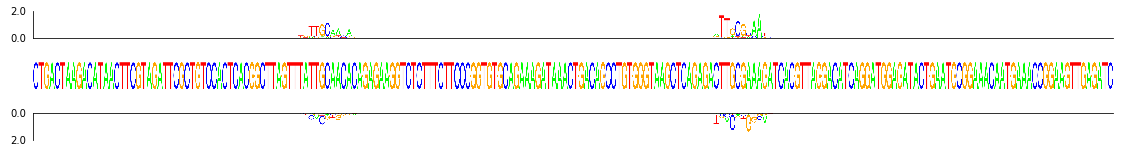

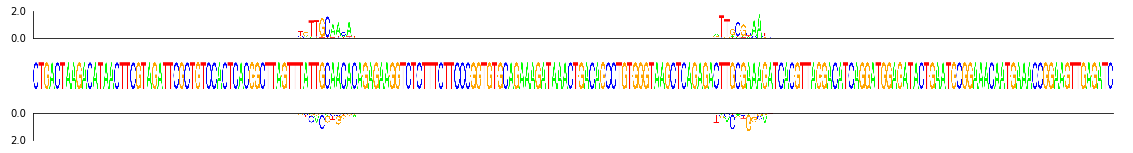

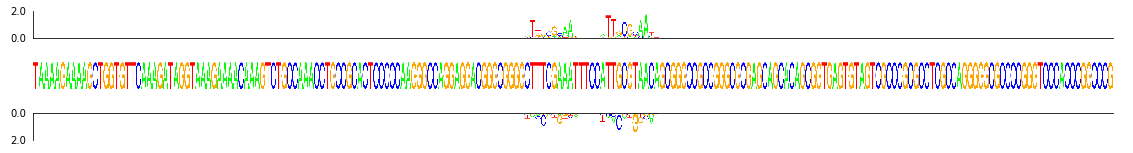

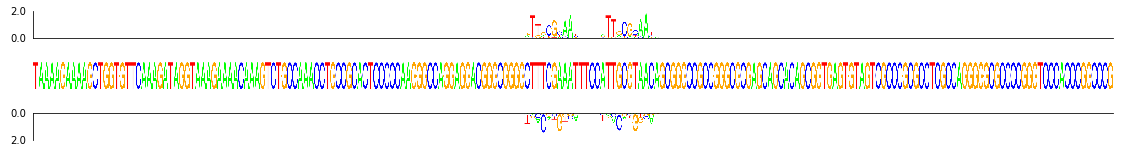

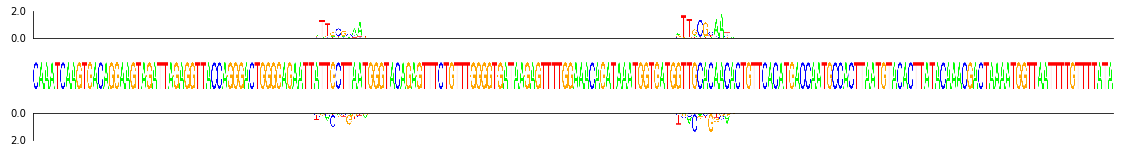

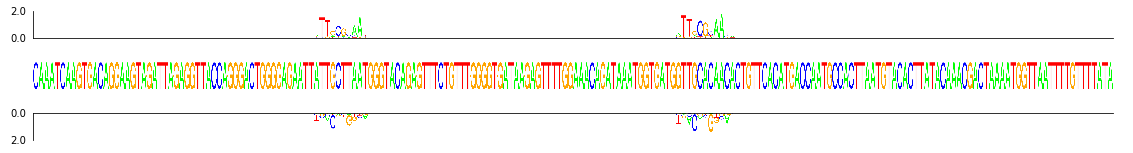

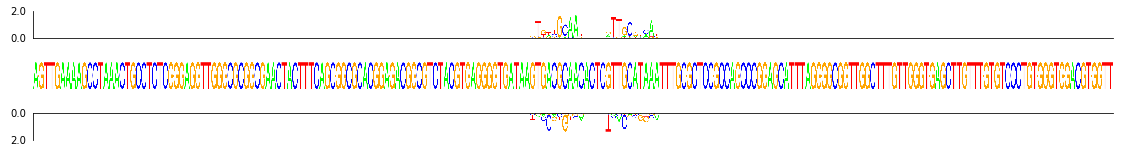

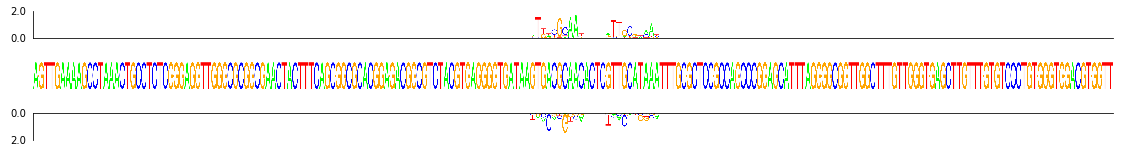

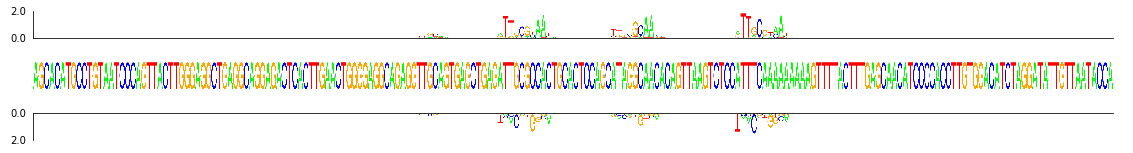

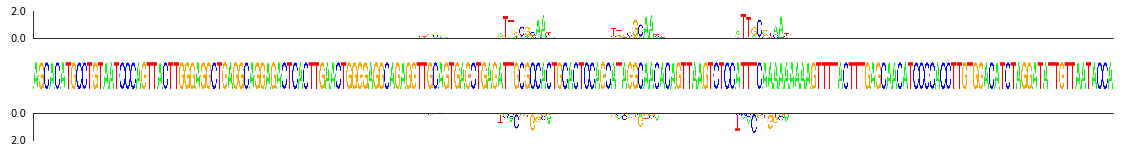

In [7]:
saliency = nntrainer.get_saliency(feed_X=valid, layer='output', method='guided')
#saliency2 = nntrainer.get_average_saliency(feed_X=valid, layer='output', method='guided', num_average=10, batch_size=200)

for index in max_index[:5]:
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)
    
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency2[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)

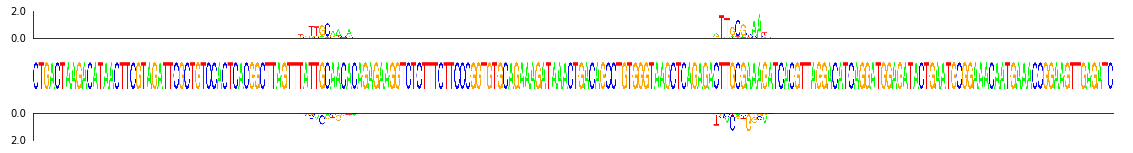

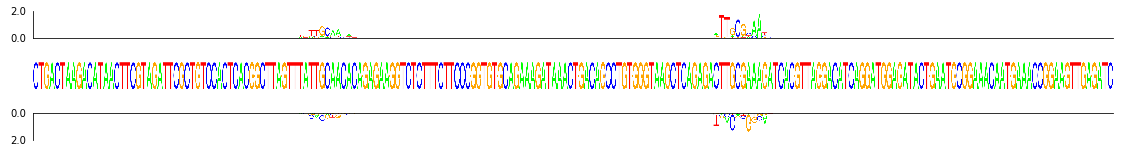

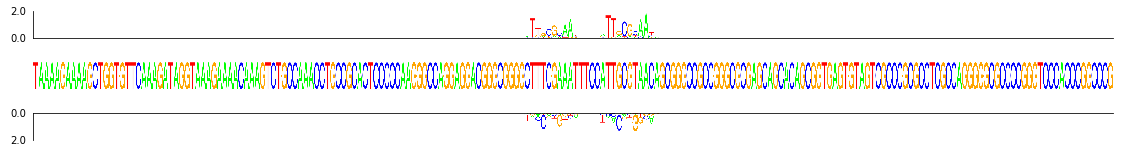

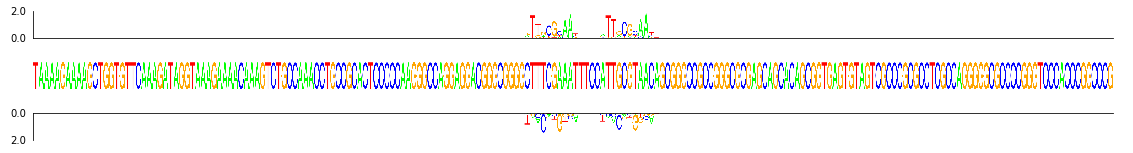

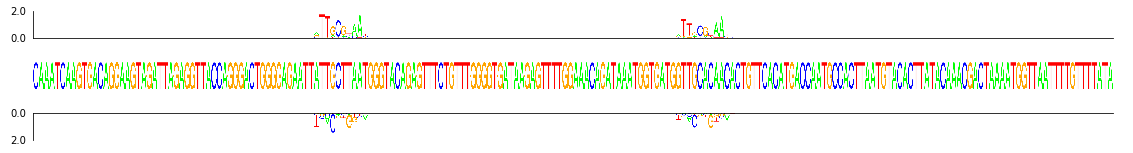

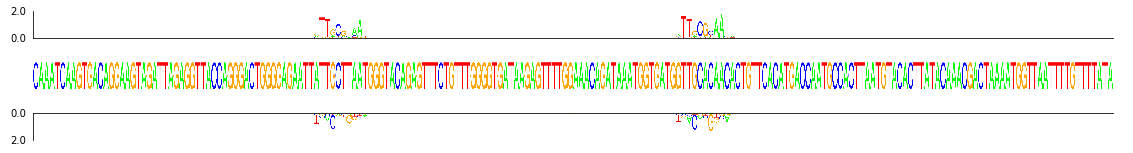

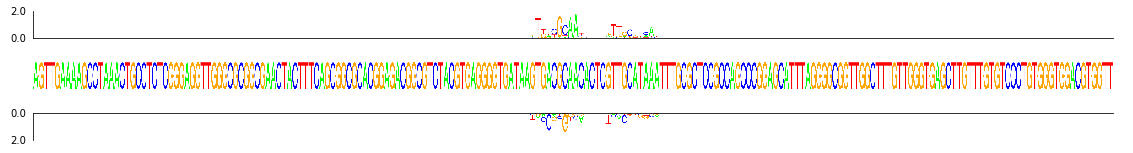

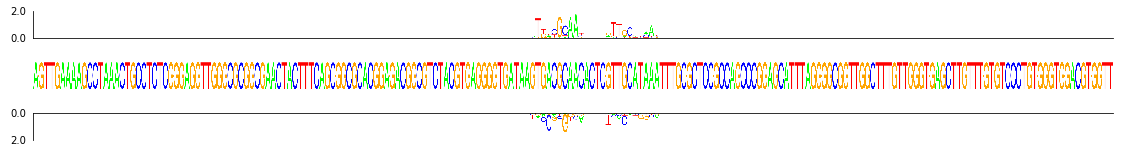

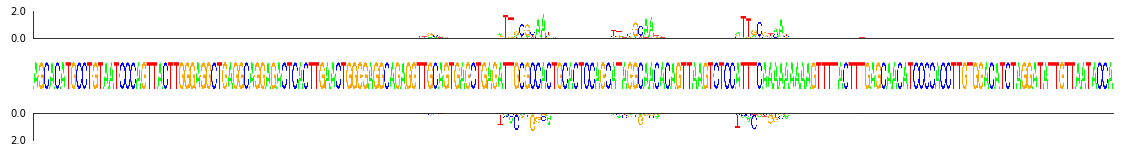

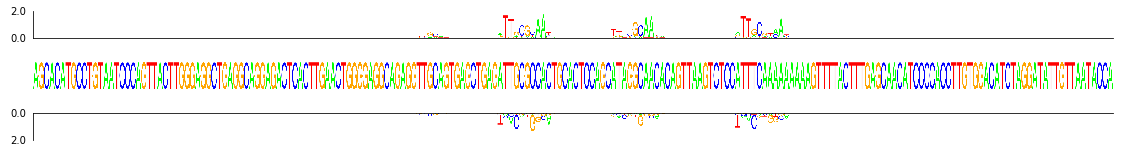

In [8]:
saliency = nntrainer.get_saliency(feed_X=valid, layer='output', method='deconv')
saliency2 = nntrainer.get_average_saliency(feed_X=valid, layer='output', method='deconv', num_average=10, batch_size=200)

for index in max_index[:5]:
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)
    
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency2[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)

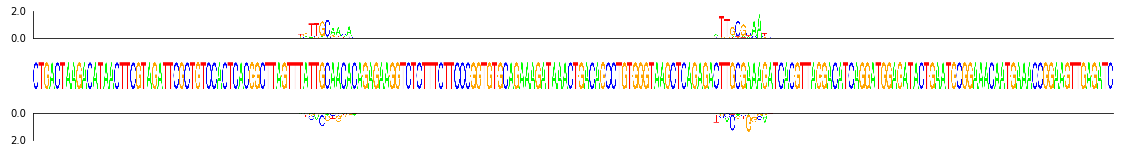

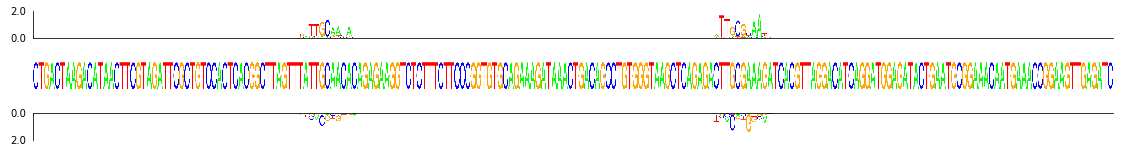

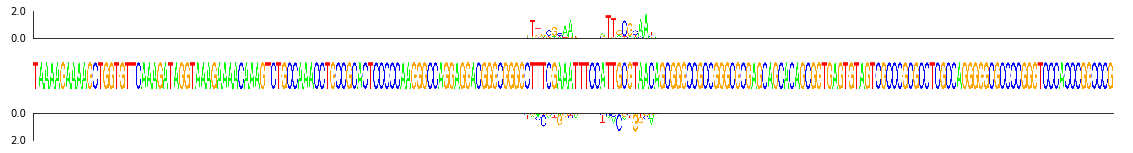

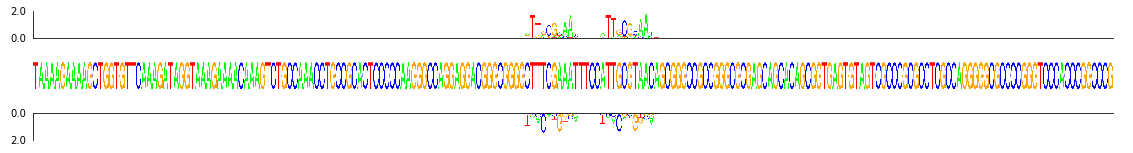

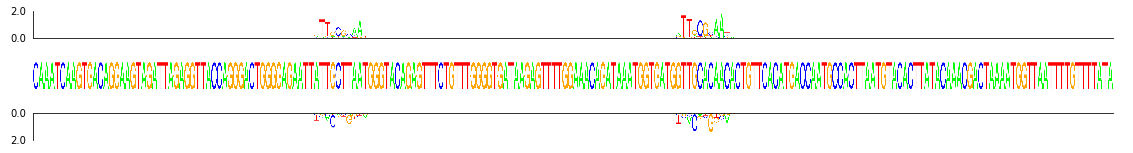

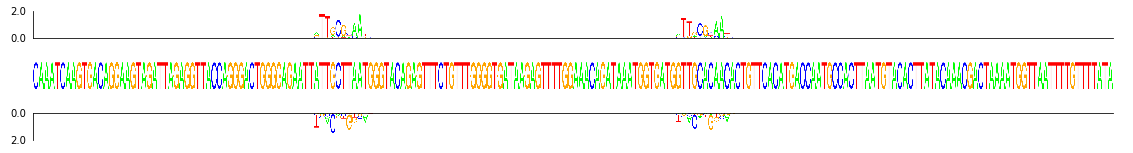

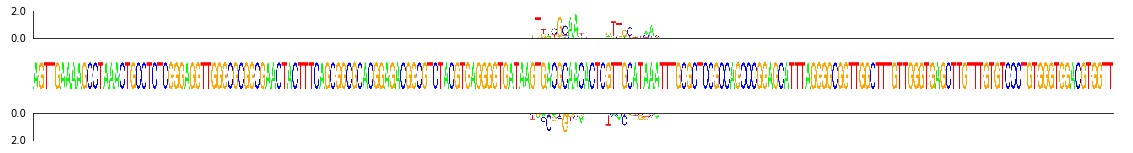

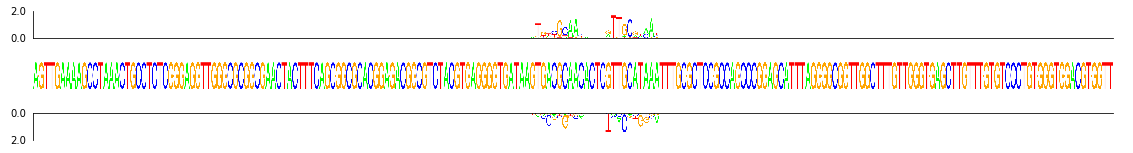

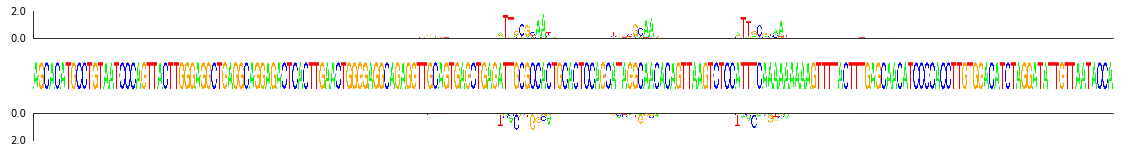

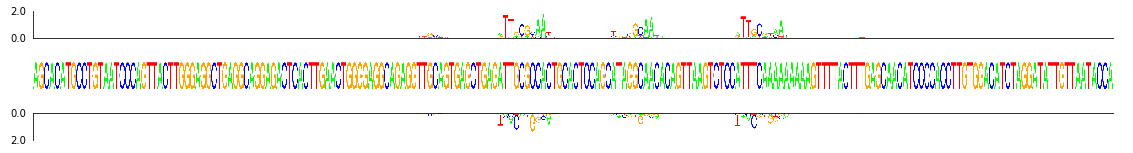

In [9]:
saliency = nntrainer.get_saliency(feed_X=valid, layer='output', method='backprop')
saliency2 = nntrainer.get_average_saliency(feed_X=valid, layer='output', method='backprop', num_average=10, batch_size=200)

for index in max_index[:5]:
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)
    
    fig, plt = visualize.plot_neg_saliency(np.squeeze(X_valid[index]).T, np.squeeze(saliency2[index].T), height=50, nt_width=20, alphabet='dna', figsize=(100,2))
    fig.set_size_inches(150, 20)